# 01_data_extraction.ipynb — Extração de Dados (ObrasGov)

## 1. Sobre

Este notebook realiza a extração dos dados a partir da API pública da plataforma ObrasGov. A plataforma oferece informações detalhadas sobre projetos de investimento em infraestrutura do governo federal, incluindo: dados do projeto, georreferenciamento, execução física e execução financeira.

Neste projeto usamos especificamente o endpoint `/projeto-investimento` filtrado por UF (neste caso, `DF`) para construir uma base local de obras que será normalizada e carregada em um banco de dados posteriormente.

O notebook está organizado em blocos didáticos: imports e ambiente, definição de parâmetros, execução da extração com paginação e tratamento de erros (incluindo backoff para 429), e armazenamento dos artefatos RAW (dados e metadados).

In [13]:
import os
import sys
import pandas as pd
import json
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

# Adiciona a pasta raiz do projeto ao sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Classe para extração de dados via API (desenvolvida em src/extractors/api_extractor.py)
from src.extractors.api_extractor import ExtratorAPI

# Carrega as variáveis do arquivo .env para o ambiente
load_dotenv()

True

## Variáveis de ambiente e credenciais

Carregamos variáveis do arquivo `.env` quando necessário. Isso mantém credenciais e configurações fora do código-fonte. A célula seguinte chama `load_dotenv()` — garanta que exista um arquivo `.env` na raiz do projeto com as chaves necessárias quando executar localmente.

Em ambientes de CI/CD ou produção, injete variáveis de ambiente usando o mecanismo seguro da plataforma (secrets, variables) em vez de comitar um arquivo `.env`.

In [5]:
# Carrega as variáveis do arquivo .env para o ambiente
# (se não houver .env a chamada é segura; load_dotenv apenas registra o que encontra)
load_dotenv()

True

## 2. Endpoint da API

### 2.1 Sobre

A API ObrasGov expõe o endpoint `/projeto-investimento` que retorna uma lista paginada de projetos. Para este projeto definimos a URL base e usaremos parâmetros de consulta para filtrar (UF), controlar paginação e ordenação.

Para a acessar a documentação oficial da API acesse: https://api.obrasgov.gestao.gov.br/obrasgov/api/swagger-ui/index.html

In [6]:
# URL da API de projetos de investimento do ObrasGov
URL_API = "https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento"

### 2.2 Parâmetros da requisição e paginação

A constante `PARAMS` define filtros (por exemplo `uf='DF'`), paginação (`pagina`, 100) e ordenação (`ordenacao`, `ID_UNICO`). A seguir estão os pontos práticos sobre paginação e tratamento de erros: 

- O **endpoint é paginado** -> para extrair tudo é necessário iterar sobre as páginas e concatenar `content`.
- Implementado **backoff incremental** para lidar com `429 Too Many Requests`. No exemplo de execução usado no repositório, um aumento de espera conforme o número de tentativas foi aplicado (e.g., 30s, 60s, 90s).
- Tratamento de erros **5xx e 4xx deve tentar re-tentar** (com limite máximo de tentativas e aplicando politicas de retry/backoff).

In [7]:
# Parametros iniciais
PARAMS = {
    'uf': 'DF',
    'pagina': 0,          
    'tamanhoDaPagina': 100,     
    'ordenacao': 'ID_UNICO'
}

## 3. Extração dos Dados

### 3.1 Instanciando o ExtratorAPI

A classe `ExtratorAPI` centraliza a lógica de requisição e paginação. Utilizada como uma abstração para: extrair dados de interesse, metadados, backoff incremental,.

In [8]:
extrator = ExtratorAPI(
    url_base=URL_API,
    params=PARAMS,
)

### 3.2 Execução da extração e salvamento (com mensagens de progresso)

A execução agrupa três responsabilidades principais:   
1) coletar `content` de cada página e concatenar no array `db_total`,   
2) armazenar metadados da página (headers, totalElements etc.) em `db_metadados`, e   
3) aplicar políticas de retry/backoff quando a API retorna 429 ou erros 5xx.  

O trecho de log exemplar a seguir mostra uma extração real com paginação e backoff incremental para 429: 


In [9]:
try:
    # O método 'executar_extracao' cuida de todo o processo
    data, metadata = extrator.executar_extracao()
    
    if data:
        
        out_dir = '../data/raw/dados_obras_gov.json'
        
        # Garante que o diretório de saída exista
        os.makedirs(os.path.dirname(out_dir), exist_ok=True)
        
        # Abre o arquivo em modo de escrita ('w') com codificação UTF-8
        with open(out_dir, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
        
        print(f"\nDados salvos com sucesso em formato JSON: {out_dir}")
        print(f"Total de registros salvos: {len(data)}")
    else:
        print("\nNenhum dado foi coletado para salvar.")

except Exception as e:
    print(f"\nO processo de extração falhou: {e}")

2025-10-17 02:05:38 - INFO - Iniciando extração da API em 'https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento'


Páginas extraídas: 0 pág [00:00, ? pág/s]

2025-10-17 02:06:04 - INFO - Requisitando URL: https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento?uf=DF&pagina=0&tamanhoDaPagina=100&ordenacao=ID_UNICO
2025-10-17 02:07:00 - INFO - Requisitando URL: https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento?uf=DF&pagina=1&tamanhoDaPagina=100&ordenacao=ID_UNICO
2025-10-17 02:07:00 - INFO - Requisitando URL: https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento?uf=DF&pagina=1&tamanhoDaPagina=100&ordenacao=ID_UNICO
2025-10-17 02:07:56 - INFO - Requisitando URL: https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento?uf=DF&pagina=2&tamanhoDaPagina=100&ordenacao=ID_UNICO
2025-10-17 02:07:56 - INFO - Requisitando URL: https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento?uf=DF&pagina=2&tamanhoDaPagina=100&ordenacao=ID_UNICO
2025-10-17 02:08:52 - INFO - Requisitando URL: https://api.obrasgov.gestao.gov.br/obrasgov/api/projeto-investimento?uf=DF&pagina=3&tamanhoDaPagina=100


Dados salvos com sucesso em formato JSON: ../data/raw/dados_obras_gov.json
Total de registros salvos: 834


In [10]:
# Transformando tudo em DataFrame
df = pd.json_normalize(data)
print(df.head())
print("Total de registros: ", len(df))

       idUnico                                               nome         cep  \
0  50379.53-54  DL - 304/2024 - Contratação de instituição par...        None   
1  42724.53-27                  Escola Classe Crixá São Sebastião        None   
2  19970.53-78  Reajuste do Contrato 45/2021 - Contrução do Ce...  70.602-600   
3  24797.53-15  Implantação de Passarelas nas Estradas Parque ...        None   
4  24822.53-70  obra de construção da  Cabine de Medição, loca...        None   

                                   endereco  \
0                                      None   
1                                      None   
2  SAIS Área Especial 3, Setor Policial Sul   
3                                      None   
4                                      None   

                                           descricao  \
0  Contratação de instituição para execução de se...   
1  Construção de Escola em Tempo Integral, Escola...   
2  Reajuste do Contrato 45/2021 - Construção do C...   
3  Imp

## 4. Visualização

### 4.1 Visualização Inicial

Utilizandos os métodos `describe()` e `info()` para analise inicial dos dados extraidos.

In [11]:
df.describe()

,idUnico,nome,cep,endereco,descricao,funcaoSocial,metaGlobal,dataInicialPrevista,dataFinalPrevista,dataInicialEfetiva,...,observacoesPertinentes,isModeladaPorBim,dataSituacao,tomadores,executores,repassadores,eixos,tipos,subTipos,fontesDeRecurso
count,834,834,395,431,834,834,834,831,831,27,...,119,592,834,834,834,834,834,834,834,834
unique,683,640,93,242,629,508,466,413,456,12,...,3,2,365,51,82,52,15,51,84,512
top,31061.53-30,CONSTRUÇÃO DE UNIDADE BÁSICA DE SAÚDE,1,,CONSTRUÇÃO DE UNIDADE BÁSICA DE SAÚDE,Segurança Pública,Escola de Educação Infantil Tipo B,2025-06-01,2027-06-01,2018-07-09,...,Informações Obras Fundo Nacional de Desenvolvi...,False,2025-07-25,[],[{'nome': 'FUNDO NACIONAL DE DESENVOLVIMENTO D...,[],"[{'id': 1, 'descricao': 'Administrativo'}]","[{'id': 5, 'descricao': 'Administrativo', 'idE...","[{'id': 36, 'descricao': 'Dragagem, Derrocamen...","[{'origem': 'Federal', 'valorInvestimentoPrevi..."
freq,3,10,82,58,10,37,52,50,48,9,...,116,559,90,484,117,390,324,125,116,131


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   idUnico                             834 non-null    object
 1   nome                                834 non-null    object
 2   cep                                 395 non-null    object
 3   endereco                            431 non-null    object
 4   descricao                           834 non-null    object
 5   funcaoSocial                        834 non-null    object
 6   metaGlobal                          834 non-null    object
 7   dataInicialPrevista                 831 non-null    object
 8   dataFinalPrevista                   831 non-null    object
 9   dataInicialEfetiva                  27 non-null     object
 10  dataFinalEfetiva                    5 non-null      object
 11  dataCadastro                        834 non-null    object

### 4.2 Visualização Avançada

#### 4.2.1 Visualização de Valores Nulos

Essa visualização mostra com clareza a **grande quantidade** de valores `"nulos"` (NaN, None, etc) nos dados extraidos da API.

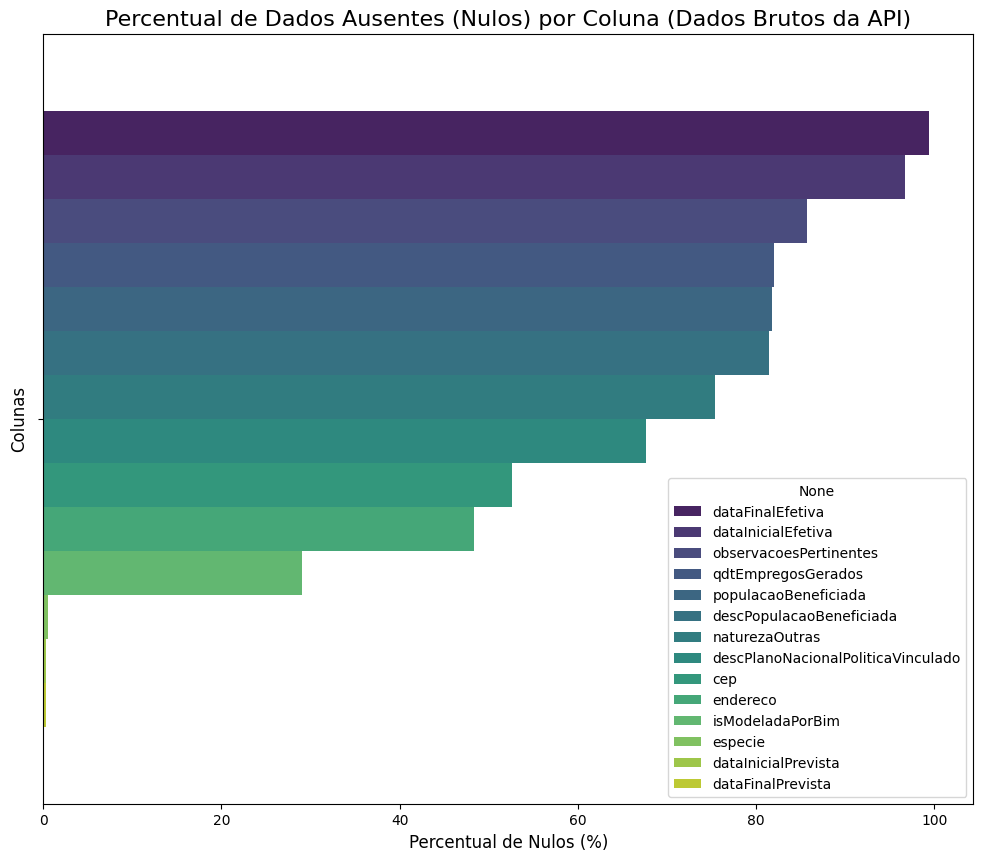

In [15]:
# 1. Calcula o percentual de nulos para cada coluna
percentual_nulos = (df.isnull().sum() / len(df)) * 100

# 2. Filtra apenas colunas que de fato têm dados ausentes (para um gráfico mais limpo)
percentual_nulos = percentual_nulos[percentual_nulos > 0].sort_values(ascending=False)

# 3. Cria a visualização
plt.figure(figsize=(12, 10))
sns.barplot(
    x=percentual_nulos, 
    hue=percentual_nulos.index, 
    palette='viridis'
)

plt.title('Percentual de Dados Ausentes (Nulos) por Coluna (Dados Brutos da API)', fontsize=16)
plt.xlabel('Percentual de Nulos (%)', fontsize=12)
plt.ylabel('Colunas', fontsize=12)
plt.show()